# Template to Exercise 1

Author: Tobias Stollenwerk, Institute for Quantum Computing Analytics (PGI-12), FZ Jülich

**Please use this template for exercise 1.3 (b)**


In [1]:
import qiskit
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import QasmSimulator
from qiskit.quantum_info import Pauli
from qiskit.visualization import array_to_latex, plot_histogram
# Imports needed for simulating noisy quantum computation
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer.noise import (NoiseModel, QuantumError)
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp

## Further information

https://qiskit.github.io/qiskit-aer/tutorials/3_building_noise_models.html

### Example Quantum Circuit

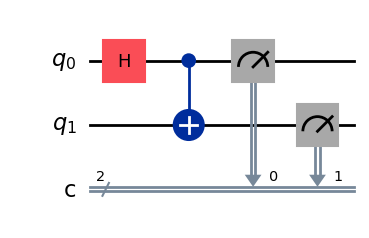

In [2]:
circuit = QuantumCircuit(2, 2)
circuit.h(0)
circuit.cx(0, 1)
circuit.measure(0, 0)
circuit.measure(1, 1);
# display the circuit
display(circuit.draw('mpl'))


## Example of quantum noise as quantum operations (Kraus operators)

Consider the following single-qubit quantum noise operation
$$
\mathcal{E}(\rho) = (1-p) I_i \rho I_i + p X_i \rho X_i
$$
that occurs whenever there is a single qubit gate applied on qubit $i$

In [3]:
p = 0.1
error_1 = [(Pauli('I'), (1-p)),
           (Pauli('X'), p)]

As well as the two-qubit quantum noise operation

$$
\mathcal{E}(\rho) = \mathcal{E}_\mathrm{II}(\rho)  +\mathcal{E}_\mathrm{IX}(\rho)  + \mathcal{E}_\mathrm{XI}(\rho) + \mathcal{E}_\mathrm{XX}(\rho) 
$$
with
$$
\mathcal{E}_\mathrm{II}(\rho) = (1-p)^2 I_i I_j \rho I_i I_j 
$$
$$
\mathcal{E}_\mathrm{IX}(\rho) = (1-p)p I_i X_j \rho I_i X_j 
$$
$$
\mathcal{E}_\mathrm{XI}(\rho) = p(1-p) X_i I_j \rho X_i I_j 
$$
$$
\mathcal{E}_\mathrm{XX}(\rho) = p^2 X_i X_j \rho X_i X_j 
$$
that occurs whenever there is a two qubit gate applied to qubits $i$ and $j$.

In [4]:
error_2 = [(Pauli('II'), (1-p)*(1-p)),
           (Pauli('IX'), (1-p)*p),
           (Pauli('XI'), p*(1-p)),
           (Pauli('XX'), p*p)]

The corresponding Kraus operators read
$$
E_\mathrm{I} = \sqrt{(1-p)} I_i 
$$
$$
E_\mathrm{X} = \sqrt{p} X_i 
$$
$$
E_\mathrm{II} = \sqrt{(1-p)^2} I_i I_j
$$
$$
E_\mathrm{IX} = \sqrt{(1-p)p} I_i X_j
$$
$$
E_\mathrm{XI} = \sqrt{p(1-p)} X_i I_j
$$
$$
E_\mathrm{XX} = \sqrt{p^2} X_i X_j
$$


In [5]:
EI = SparsePauliOp("I", np.sqrt((1-p)))
EX = SparsePauliOp("X", np.sqrt(p))

In [6]:
EII = SparsePauliOp("II", np.sqrt((1-p)*(1-p)))
EIX = SparsePauliOp("IX", np.sqrt((1-p)*p))
EXI = SparsePauliOp("XI", np.sqrt(p*(1-p)))
EXX = SparsePauliOp("XX", np.sqrt(p*p))

In [7]:
error_1 = QuantumError(Kraus([EI.to_matrix(), EX.to_matrix()]))
error_2 = QuantumError(Kraus([EII.to_matrix(), 
                              EIX.to_matrix(),
                              EXI.to_matrix(),
                              EXX.to_matrix()]))
# note that both ways to construct error_1 and error_2 are equivalent

## Noise model for the simulation

In [8]:
# Create an empty noise model
noise_model = NoiseModel()

# Add bit flip error to H, X, and R_Z gates
noise_model.add_all_qubit_quantum_error(error_1, ['h', 'x', 'rz'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

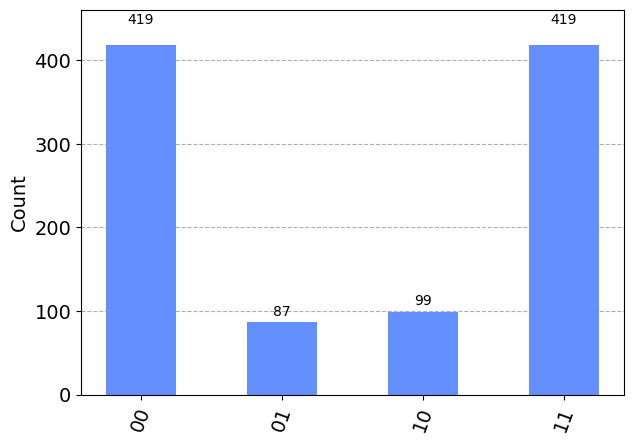

In [9]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_model)

# Transpile circuit for noisy basis gates
circuit_with_noise = transpile(circuit, sim_noise)

# Run and get counts
result = sim_noise.run(circuit_with_noise).result()
counts = result.get_counts(0)

# Plot noisy output
plot_histogram(counts)

## Ideal simulation

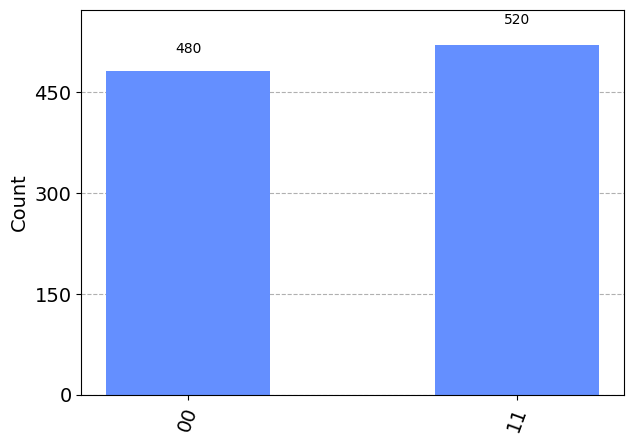

In [10]:
simulator = QasmSimulator()
job = simulator.run(circuit, shots=1000)
result = job.result()
counts = result.get_counts()
display(plot_histogram(counts))
